Using device: cuda
✓ Kaggle credentials configured
Dataset URL: https://www.kaggle.com/datasets/jessicali9530/lfw-dataset
License(s): other
lfw-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
replace lfw_data/lfw-deepfunneled/lfw-deepfunneled/AJ_Cook/AJ_Cook_0001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
✓ Dataset downloaded and extracted
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.3/379.3 kB 12.0 MB/s eta 0:00:00
Processing images and predicting gender from names...


Processing folders:   0%|          | 0/5749 [00:00<?, ?it/s]


✓ Dataset organized:
  - Male images: 9256
  - Female images: 2818
  - Unknown gender: 1159 (excluded from training)
Male: 6479 train, 1388 val, 1389 test
Female: 1972 train, 423 val, 423 test
✓ Data split completed


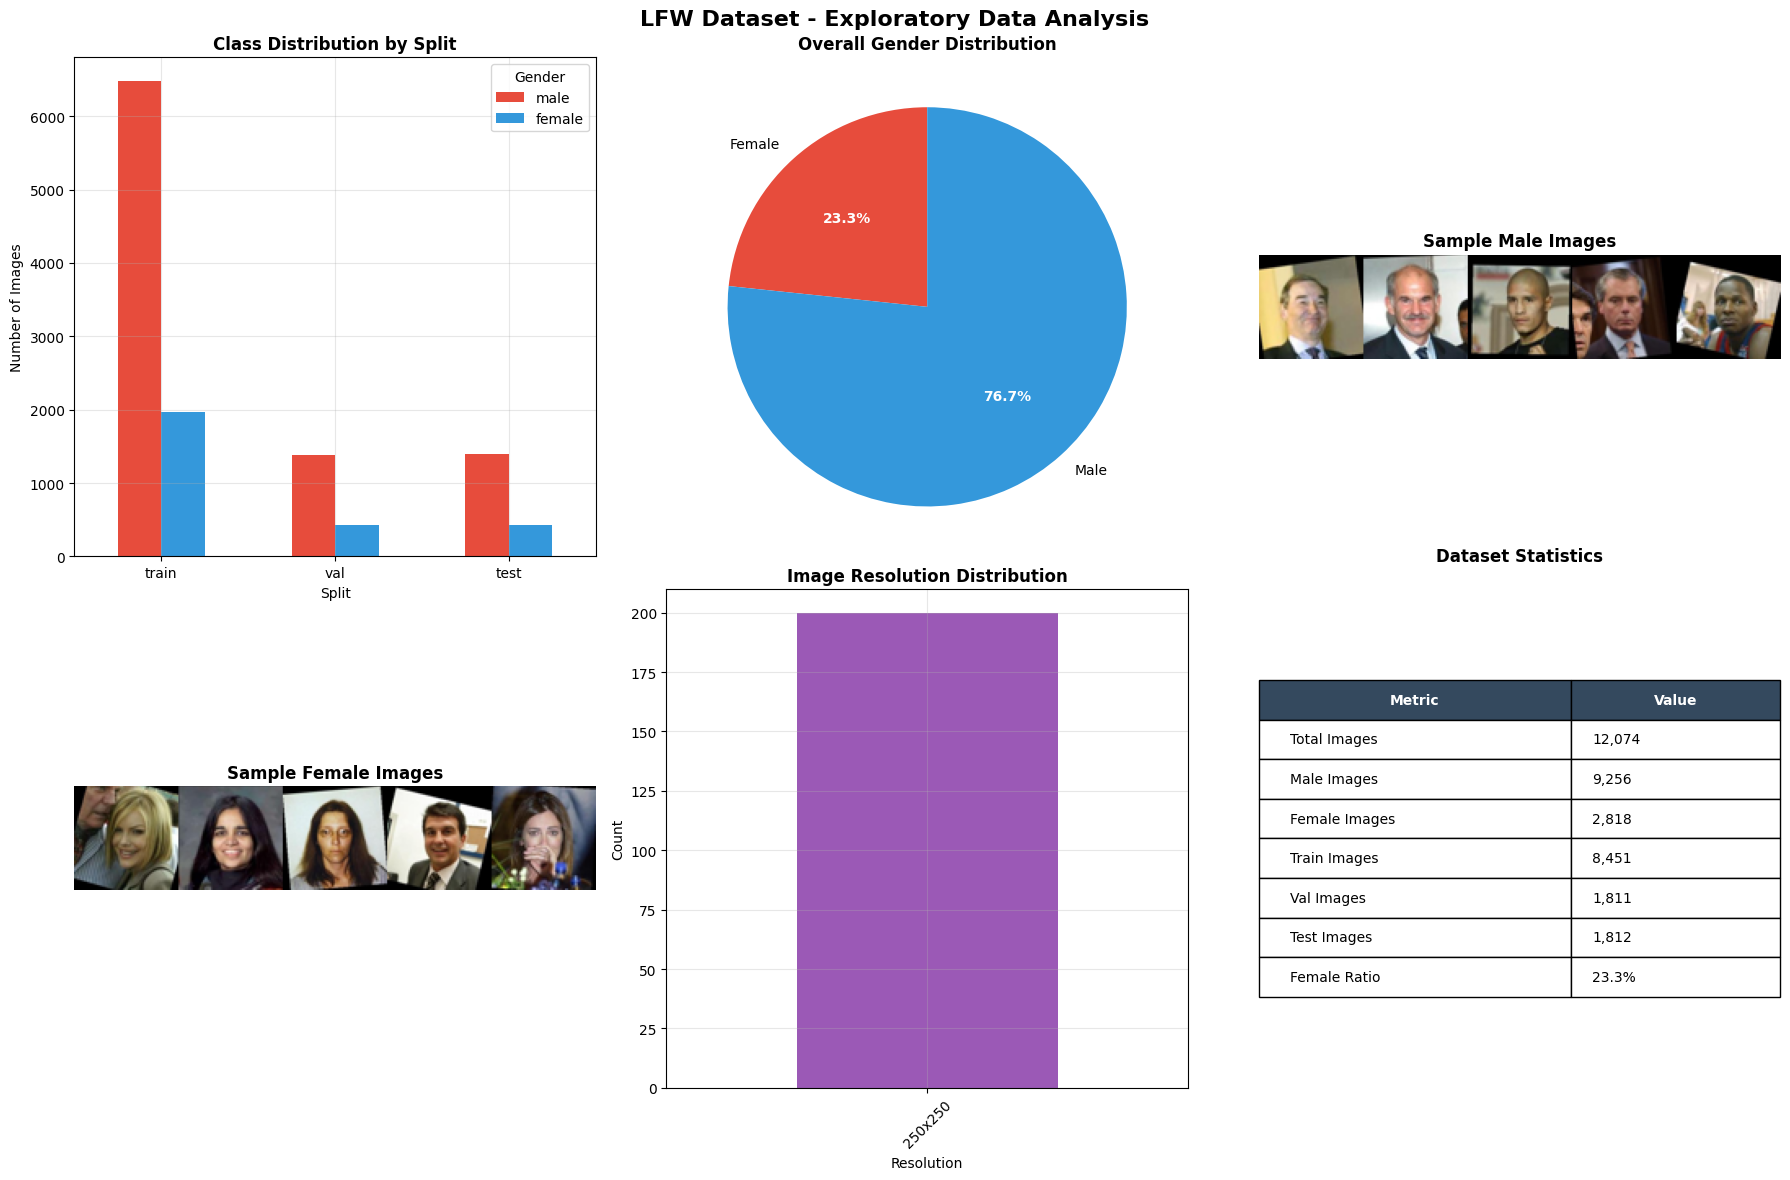

✓ EDA completed and saved

✓ Datasets created:
  - Train: 8451 samples
  - Val: 1811 samples
  - Test: 1812 samples
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 185MB/s]



✓ Model created (ResNet18)
  - Total parameters: 11,177,538
  - Trainable parameters: 11,177,538


In [2]:
# ============================================================================
# 1. SETUP AND CONFIGURATION
# ============================================================================

import os
import json
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ============================================================================
# 2. KAGGLE CREDENTIALS SETUP
# ============================================================================

kaggle_creds = {
    "username": "yassineyahyaouii",
    "key": "6e0ebf67d37bb1c91dc21f7861a27c77"
}

# Create .kaggle directory
kaggle_dir = Path.home() / '.kaggle'
kaggle_dir.mkdir(exist_ok=True)

# Write credentials
kaggle_json_path = kaggle_dir / 'kaggle.json'
with open(kaggle_json_path, 'w') as f:
    json.dump(kaggle_creds, f)

# Set permissions
os.chmod(kaggle_json_path, 0o600)
print("✓ Kaggle credentials configured")

# ============================================================================
# 3. DOWNLOAD AND EXTRACT DATASET
# ============================================================================

# Download dataset
!kaggle datasets download -d jessicali9530/lfw-dataset

# Extract dataset
!unzip -q lfw-dataset.zip -d lfw_data
print("✓ Dataset downloaded and extracted")

# ============================================================================
# 4. INSTALL AND USE GENDER DETECTION
# ============================================================================

# Install gender-guesser library
!pip install -q gender-guesser

import gender_guesser.detector as gender

# ============================================================================
# 5. DATA PREPROCESSING AND ORGANIZATION
# ============================================================================

def get_gender_from_name(name):
    """Predict gender from first name using gender_guesser"""
    d = gender.Detector()

    # Extract first name from full name
    first_name = name.split('_')[0]

    # Get gender prediction
    result = d.get_gender(first_name)

    # Map results to binary (male/female)
    # 'mostly_male' and 'male' -> 'male'
    # 'mostly_female' and 'female' -> 'female'
    # 'unknown' or 'andy' (androgynous) -> None
    if result in ['male', 'mostly_male']:
        return 'male'
    elif result in ['female', 'mostly_female']:
        return 'female'
    else:
        return None

def organize_dataset():
    """Organize images into male/female folders using name-based gender prediction"""

    # Source and destination paths
    source_dir = Path('lfw_data/lfw-deepfunneled/lfw-deepfunneled')
    dest_dir = Path('lfw_organized')
    dest_dir.mkdir(exist_ok=True)

    # Create male/female directories
    male_dir = dest_dir / 'male'
    female_dir = dest_dir / 'female'
    unknown_dir = dest_dir / 'unknown'
    male_dir.mkdir(exist_ok=True)
    female_dir.mkdir(exist_ok=True)
    unknown_dir.mkdir(exist_ok=True)

    male_count = 0
    female_count = 0
    unknown_count = 0

    print("Processing images and predicting gender from names...")

    # Process each person's folder
    person_folders = list(source_dir.iterdir())
    for person_folder in tqdm(person_folders, desc="Processing folders"):
        if not person_folder.is_dir():
            continue

        person_name = person_folder.name

        # Predict gender for this person
        gender_pred = get_gender_from_name(person_name)

        if gender_pred is None:
            target_dir = unknown_dir
            unknown_count += len(list(person_folder.glob('*.jpg')))
        elif gender_pred == 'male':
            target_dir = male_dir
            male_count += len(list(person_folder.glob('*.jpg')))
        else:
            target_dir = female_dir
            female_count += len(list(person_folder.glob('*.jpg')))

        # Copy all images for this person
        for img_file in person_folder.glob('*.jpg'):
            target_file = target_dir / f"{person_name}_{img_file.name}"
            shutil.copy2(img_file, target_file)

    print(f"\n✓ Dataset organized:")
    print(f"  - Male images: {male_count}")
    print(f"  - Female images: {female_count}")
    print(f"  - Unknown gender: {unknown_count} (excluded from training)")

    # Check if we have enough data
    if male_count < 100 or female_count < 100:
        print(f"\n⚠ WARNING: Low number of images detected.")
        print(f"This might affect model performance.")

    return dest_dir

# Organize the dataset
organized_dir = organize_dataset()

# ============================================================================
# 6. TRAIN/VAL/TEST SPLIT
# ============================================================================

def create_splits(data_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """Split data into train/val/test sets"""

    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6

    split_dir = Path('lfw_splits')
    split_dir.mkdir(exist_ok=True)

    for split in ['train', 'val', 'test']:
        for gender in ['male', 'female']:
            (split_dir / split / gender).mkdir(parents=True, exist_ok=True)

    # Process each gender
    for gender in ['male', 'female']:
        gender_dir = data_dir / gender
        images = list(gender_dir.glob('*.jpg'))

        if len(images) == 0:
            print(f"⚠ WARNING: No images found for {gender}")
            continue

        # Split data
        train_imgs, temp_imgs = train_test_split(images, train_size=train_ratio, random_state=42)
        val_imgs, test_imgs = train_test_split(temp_imgs, train_size=val_ratio/(val_ratio+test_ratio), random_state=42)

        # Copy files
        for img_list, split in [(train_imgs, 'train'), (val_imgs, 'val'), (test_imgs, 'test')]:
            for img in img_list:
                target = split_dir / split / gender / img.name
                shutil.copy2(img, target)

        print(f"{gender.capitalize()}: {len(train_imgs)} train, {len(val_imgs)} val, {len(test_imgs)} test")

    return split_dir

split_dir = create_splits(organized_dir)
print("✓ Data split completed")

# ============================================================================
# 7. EXPLORATORY DATA ANALYSIS (EDA)
# ============================================================================

def perform_eda(split_dir):
    """Perform comprehensive EDA"""

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('LFW Dataset - Exploratory Data Analysis', fontsize=16, fontweight='bold')

    # 1. Class Distribution
    counts = {'train': {}, 'val': {}, 'test': {}}
    for split in ['train', 'val', 'test']:
        for gender in ['male', 'female']:
            count = len(list((split_dir / split / gender).glob('*.jpg')))
            counts[split][gender] = count

    # Plot class distribution
    ax = axes[0, 0]
    df_counts = pd.DataFrame(counts).T
    df_counts.plot(kind='bar', ax=ax, color=['#e74c3c', '#3498db'])
    ax.set_title('Class Distribution by Split', fontsize=12, fontweight='bold')
    ax.set_xlabel('Split')
    ax.set_ylabel('Number of Images')
    ax.legend(title='Gender')
    ax.grid(True, alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)

    # 2. Overall class balance
    ax = axes[0, 1]
    total_male = sum(counts[s]['male'] for s in counts)
    total_female = sum(counts[s]['female'] for s in counts)
    colors = ['#e74c3c', '#3498db']
    wedges, texts, autotexts = ax.pie([total_female, total_male],
                                       labels=['Female', 'Male'],
                                       autopct='%1.1f%%',
                                       colors=colors,
                                       startangle=90)
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    ax.set_title('Overall Gender Distribution', fontsize=12, fontweight='bold')

    # 3. Sample images - Male
    ax = axes[0, 2]
    male_imgs = list((split_dir / 'train' / 'male').glob('*.jpg'))[:5]
    if male_imgs:
        combined = np.hstack([np.array(Image.open(img).resize((64, 64))) for img in male_imgs[:5]])
        ax.imshow(combined)
        ax.set_title('Sample Male Images', fontsize=12, fontweight='bold')
        ax.axis('off')
    else:
        ax.text(0.5, 0.5, 'No male images', ha='center', va='center')
        ax.axis('off')

    # 4. Sample images - Female
    ax = axes[1, 0]
    female_imgs = list((split_dir / 'train' / 'female').glob('*.jpg'))[:5]
    if female_imgs:
        combined = np.hstack([np.array(Image.open(img).resize((64, 64))) for img in female_imgs[:5]])
        ax.imshow(combined)
        ax.set_title('Sample Female Images', fontsize=12, fontweight='bold')
        ax.axis('off')
    else:
        ax.text(0.5, 0.5, 'No female images', ha='center', va='center')
        ax.axis('off')

    # 5. Image resolution analysis
    ax = axes[1, 1]
    resolutions = []
    for gender in ['male', 'female']:
        imgs = list((split_dir / 'train' / gender).glob('*.jpg'))[:100]
        for img_path in imgs:
            img = Image.open(img_path)
            resolutions.append(f"{img.size[0]}x{img.size[1]}")

    if resolutions:
        res_counts = pd.Series(resolutions).value_counts()
        res_counts.plot(kind='bar', ax=ax, color='#9b59b6')
        ax.set_title('Image Resolution Distribution', fontsize=12, fontweight='bold')
        ax.set_xlabel('Resolution')
        ax.set_ylabel('Count')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3)

    # 6. Statistics table
    ax = axes[1, 2]
    ax.axis('off')
    total_images = total_male + total_female
    stats_data = [
        ['Total Images', f"{total_images:,}"],
        ['Male Images', f"{total_male:,}"],
        ['Female Images', f"{total_female:,}"],
        ['Train Images', f"{sum(counts['train'].values()):,}"],
        ['Val Images', f"{sum(counts['val'].values()):,}"],
        ['Test Images', f"{sum(counts['test'].values()):,}"],
        ['Female Ratio', f"{(total_female/total_images)*100:.1f}%"]
    ]
    table = ax.table(cellText=stats_data, colLabels=['Metric', 'Value'],
                     cellLoc='left', loc='center', colWidths=[0.6, 0.4])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    # Style the header
    for i in range(2):
        table[(0, i)].set_facecolor('#34495e')
        table[(0, i)].set_text_props(weight='bold', color='white')
    ax.set_title('Dataset Statistics', fontsize=12, fontweight='bold', pad=20)

    plt.tight_layout()
    plt.savefig('eda_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✓ EDA completed and saved")

perform_eda(split_dir)

# ============================================================================
# 8. DATASET AND DATALOADER
# ============================================================================

class GenderDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.samples = []

        # female=0, male=1
        for gender_idx, gender in enumerate(['female', 'male']):
            gender_dir = self.root_dir / gender
            if not gender_dir.exists():
                continue
            for img_path in gender_dir.glob('*.jpg'):
                self.samples.append((str(img_path), gender_idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = GenderDataset(split_dir / 'train', transform=train_transform)
val_dataset = GenderDataset(split_dir / 'val', transform=test_transform)
test_dataset = GenderDataset(split_dir / 'test', transform=test_transform)

print(f"\n✓ Datasets created:")
print(f"  - Train: {len(train_dataset)} samples")
print(f"  - Val: {len(val_dataset)} samples")
print(f"  - Test: {len(test_dataset)} samples")

# Check if we have enough data
if len(train_dataset) < 100:
    print("\n⚠ WARNING: Very small training set. Results may not be reliable.")
    print("Consider using a different dataset or additional data sources.")

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# ============================================================================
# 9. MODEL DEFINITION
# ============================================================================

class GenderClassifier(nn.Module):
    def __init__(self, pretrained=True):
        super(GenderClassifier, self).__init__()
        # Use ResNet18 as backbone
        self.backbone = models.resnet18(pretrained=pretrained)
        num_features = self.backbone.fc.in_features
        # Add dropout for regularization
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(num_features, 2)
        )

    def forward(self, x):
        return self.backbone(x)

model = GenderClassifier(pretrained=True).to(device)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n✓ Model created (ResNet18)")
print(f"  - Total parameters: {total_params:,}")
print(f"  - Trainable parameters: {trainable_params:,}")

In [5]:
# ============================================================================
# 10. TRAINING
# ============================================================================

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc='Training', leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({'loss': f'{loss.item():.4f}',
                         'acc': f'{100.*correct/total:.2f}%'})

    return running_loss / len(loader), 100. * correct / total

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Validation', leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return running_loss / len(loader), 100. * correct / total

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

# Training loop
num_epochs = 3
best_val_acc = 0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60 + "\n")

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 40)

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    scheduler.step(val_loss)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model_lfw.pth')
        print(f"✓ Model saved (Val Acc: {val_acc:.2f}%)")

print("\n" + "="*60)
print("TRAINING COMPLETED")
print("="*60)
print(f"Best Validation Accuracy: {best_val_acc:.2f}%\n")


STARTING TRAINING


Epoch 1/3
----------------------------------------


Training:   0%|          | 0/265 [00:00<?, ?it/s]

Validation:   0%|          | 0/57 [00:00<?, ?it/s]

Train Loss: 0.1742 | Train Acc: 94.45%
Val Loss: 0.1605 | Val Acc: 95.03%
✓ Model saved (Val Acc: 95.03%)

Epoch 2/3
----------------------------------------


Training:   0%|          | 0/265 [00:00<?, ?it/s]

Validation:   0%|          | 0/57 [00:00<?, ?it/s]

Train Loss: 0.1690 | Train Acc: 94.78%
Val Loss: 0.1339 | Val Acc: 95.91%
✓ Model saved (Val Acc: 95.91%)

Epoch 3/3
----------------------------------------


Training:   0%|          | 0/265 [00:00<?, ?it/s]

Validation:   0%|          | 0/57 [00:00<?, ?it/s]

Train Loss: 0.1529 | Train Acc: 95.18%
Val Loss: 0.1440 | Val Acc: 95.80%

TRAINING COMPLETED
Best Validation Accuracy: 95.91%



In [6]:
# ============================================================================
# 11. EVALUATION
# ============================================================================

def evaluate_model(model, loader, device):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Evaluating', leave=False):
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

# Load best model
model.load_state_dict(torch.load('best_model_lfw.pth'))
print("Evaluating on test set...")
test_labels, test_preds, test_probs = evaluate_model(model, test_loader, device)

Evaluating on test set...


Evaluating:   0%|          | 0/57 [00:00<?, ?it/s]

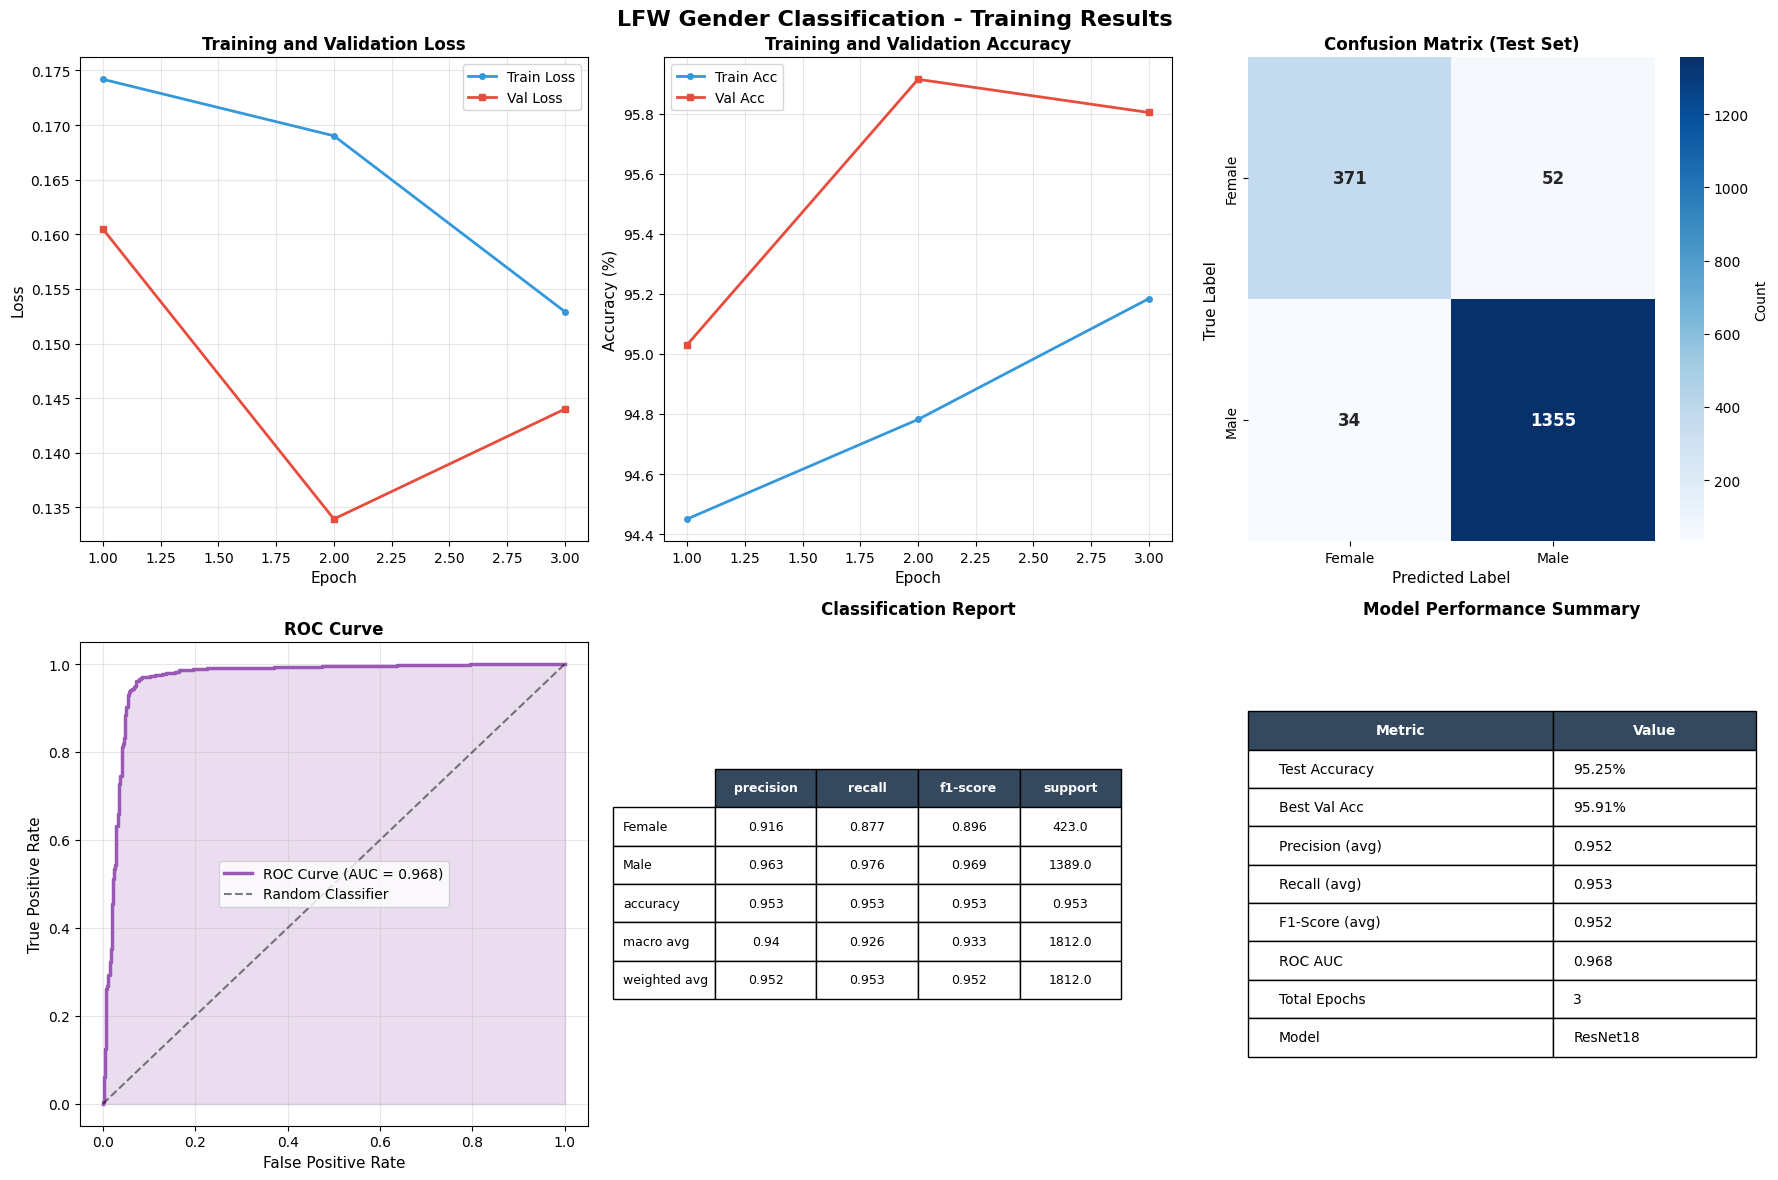


✓ Results visualization saved


In [7]:
# ============================================================================
# 12. RESULTS VISUALIZATION
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('LFW Gender Classification - Training Results', fontsize=16, fontweight='bold')

# 1. Training and Validation Loss
ax = axes[0, 0]
epochs_range = range(1, len(history['train_loss']) + 1)
ax.plot(epochs_range, history['train_loss'], label='Train Loss', linewidth=2, color='#3498db', marker='o', markersize=4)
ax.plot(epochs_range, history['val_loss'], label='Val Loss', linewidth=2, color='#e74c3c', marker='s', markersize=4)
ax.set_xlabel('Epoch', fontsize=11)
ax.set_ylabel('Loss', fontsize=11)
ax.set_title('Training and Validation Loss', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 2. Training and Validation Accuracy
ax = axes[0, 1]
ax.plot(epochs_range, history['train_acc'], label='Train Acc', linewidth=2, color='#3498db', marker='o', markersize=4)
ax.plot(epochs_range, history['val_acc'], label='Val Acc', linewidth=2, color='#e74c3c', marker='s', markersize=4)
ax.set_xlabel('Epoch', fontsize=11)
ax.set_ylabel('Accuracy (%)', fontsize=11)
ax.set_title('Training and Validation Accuracy', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 3. Confusion Matrix
ax = axes[0, 2]
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar_kws={'label': 'Count'},
            xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'],
            annot_kws={'fontsize': 12, 'fontweight': 'bold'})
ax.set_title('Confusion Matrix (Test Set)', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=11)
ax.set_xlabel('Predicted Label', fontsize=11)

# 4. ROC Curve
ax = axes[1, 0]
fpr, tpr, _ = roc_curve(test_labels, test_probs[:, 1])
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, linewidth=2.5, label=f'ROC Curve (AUC = {roc_auc:.3f})', color='#9b59b6')
ax.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random Classifier', alpha=0.5)
ax.fill_between(fpr, tpr, alpha=0.2, color='#9b59b6')
ax.set_xlabel('False Positive Rate', fontsize=11)
ax.set_ylabel('True Positive Rate', fontsize=11)
ax.set_title('ROC Curve', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 5. Classification Report
ax = axes[1, 1]
ax.axis('off')
report = classification_report(test_labels, test_preds,
                               target_names=['Female', 'Male'],
                               output_dict=True)
report_df = pd.DataFrame(report).T.round(3)
report_df = report_df[['precision', 'recall', 'f1-score', 'support']]
table = ax.table(cellText=report_df.values, colLabels=report_df.columns,
                 rowLabels=report_df.index, cellLoc='center', loc='center',
                 colWidths=[0.2, 0.2, 0.2, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)
# Style header row
for i in range(len(report_df.columns)):
    table[(0, i)].set_facecolor('#34495e')
    table[(0, i)].set_text_props(weight='bold', color='white')
ax.set_title('Classification Report', fontsize=12, fontweight='bold', pad=20)

# 6. Performance Metrics Summary
ax = axes[1, 2]
ax.axis('off')
test_acc = 100 * (test_preds == test_labels).mean()
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1 = report['weighted avg']['f1-score']

metrics_data = [
    ['Test Accuracy', f'{test_acc:.2f}%'],
    ['Best Val Acc', f'{best_val_acc:.2f}%'],
    ['Precision (avg)', f'{precision:.3f}'],
    ['Recall (avg)', f'{recall:.3f}'],
    ['F1-Score (avg)', f'{f1:.3f}'],
    ['ROC AUC', f'{roc_auc:.3f}'],
    ['Total Epochs', str(num_epochs)],
    ['Model', 'ResNet18']
]
table = ax.table(cellText=metrics_data, colLabels=['Metric', 'Value'],
                 cellLoc='left', loc='center', colWidths=[0.6, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
# Style header row
for i in range(2):
    table[(0, i)].set_facecolor('#34495e')
    table[(0, i)].set_text_props(weight='bold', color='white')
ax.set_title('Model Performance Summary', fontsize=12, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('training_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Results visualization saved")



In [8]:
# ============================================================================
# 13. FINAL REPORT
# ============================================================================

print("\n" + "="*70)
print("FINAL EVALUATION REPORT - LFW GENDER CLASSIFICATION")
print("="*70)
print(f"\nModel: ResNet18 (Fine-tuned)")
print(f"Dataset: Labeled Faces in the Wild (LFW)")
print(f"Task: Binary Gender Classification (Name-based labeling)")
print(f"Gender Detection Method: gender-guesser library")
print(f"\nDataset Statistics:")
print(f"  - Total images: {len(train_dataset) + len(val_dataset) + len(test_dataset)}")
print(f"  - Training set: {len(train_dataset)}")
print(f"  - Validation set: {len(val_dataset)}")
print(f"  - Test set: {len(test_dataset)}")
print(f"\nTraining Configuration:")
print(f"  - Epochs: {num_epochs}")
print(f"  - Batch size: {batch_size}")
print(f"  - Optimizer: AdamW (weight_decay=0.01)")
print(f"  - Learning rate: 0.001 (ReduceLROnPlateau)")
print(f"  - Device: {device}")
print(f"\nFinal Results:")
print(f"  - Test Accuracy: {test_acc:.2f}%")
print(f"  - Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"  - ROC AUC: {roc_auc:.3f}")
print(f"  - Precision (weighted): {precision:.3f}")
print(f"  - Recall (weighted): {recall:.3f}")
print(f"  - F1-Score (weighted): {f1:.3f}")
print(f"\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=['Female', 'Male']))
print("="*70)
print("\n✓ Model ready for federated learning aggregation")
print(f"✓ Model weights saved to: best_model_lfw.pth")
print(f"✓ Results saved to: training_results.png and eda_analysis.png")
print("="*70 + "\n")

# Save model state dict for federated learning
torch.save({
    'model_state_dict': model.state_dict(),
    'test_accuracy': test_acc,
    'val_accuracy': best_val_acc,
    'roc_auc': roc_auc,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'confusion_matrix': cm.tolist(),
    'history': history,
    'num_train_samples': len(train_dataset),
    'num_val_samples': len(val_dataset),
    'num_test_samples': len(test_dataset)
}, 'lfw_client_model.pth')

print("✓ Complete model checkpoint saved for federated learning: lfw_client_model.pth")


FINAL EVALUATION REPORT - LFW GENDER CLASSIFICATION

Model: ResNet18 (Fine-tuned)
Dataset: Labeled Faces in the Wild (LFW)
Task: Binary Gender Classification (Name-based labeling)
Gender Detection Method: gender-guesser library

Dataset Statistics:
  - Total images: 12074
  - Training set: 8451
  - Validation set: 1811
  - Test set: 1812

Training Configuration:
  - Epochs: 3
  - Batch size: 32
  - Optimizer: AdamW (weight_decay=0.01)
  - Learning rate: 0.001 (ReduceLROnPlateau)
  - Device: cuda

Final Results:
  - Test Accuracy: 95.25%
  - Best Validation Accuracy: 95.91%
  - ROC AUC: 0.968
  - Precision (weighted): 0.952
  - Recall (weighted): 0.953
  - F1-Score (weighted): 0.952

Classification Report:
              precision    recall  f1-score   support

      Female       0.92      0.88      0.90       423
        Male       0.96      0.98      0.97      1389

    accuracy                           0.95      1812
   macro avg       0.94      0.93      0.93      1812
weighted avg